<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Sarcasm_Detection_with_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the dataset

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-04-07 09:25:41--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2023-04-07 09:25:41 (87.0 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

with open('./sarcasm.json', 'r') as file:
  data = json.load(file)

In [3]:
sentences = []
labels = []
urls = []

for entry in data:
  sentences.append(entry.get('headline'))
  labels.append(entry.get('is_sarcastic'))
  urls.append(entry.get('article_link'))

In [4]:
train_split = 0.8
train_size = int(train_split * len(sentences))

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]
test_sentences = sentences[train_size:]
test_labels = labels[train_size:]

In [5]:
print('Train size:', len(train_sentences))
print('Test size:', len(test_sentences))

Train size: 21367
Test size: 5342


### Preprocessing

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = ''
max_sequence_len = 32
padding_type = 'post'
truncate_type = 'post'
max_vocab = 10000
embedding_dims = 16

tokenizer = Tokenizer(oov_token=oov_token, num_words=max_vocab)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print('Word index size:', len(word_index))

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences,
                             maxlen=max_sequence_len,
                             padding=padding_type,
                             truncating=truncate_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,
                            maxlen=max_sequence_len,
                            padding=padding_type,
                            truncating=truncate_type)

# convert data as numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
     

Word index size: 26507


## Build model

In [7]:
import tensorflow as tf

In [8]:
embedding_dims = 16
lstm_dims = 32
dense_dims = 24

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, embedding_dims, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dims)),
    tf.keras.layers.Dense(dense_dims, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
EPOCHS = 10

history = model.fit(train_padded,
                    train_labels,
                    epochs=EPOCHS,
                    validation_data=(test_padded, test_labels))


Epoch 1/10
668/668 [==============================] - 30s 36ms/step - loss: 0.4062 - accuracy: 0.8009 - val_loss: 0.3273 - val_accuracy: 0.8570
Epoch 2/10
668/668 [==============================] - 18s 27ms/step - loss: 0.2229 - accuracy: 0.9086 - val_loss: 0.3393 - val_accuracy: 0.8572
Epoch 3/10
668/668 [==============================] - 19s 29ms/step - loss: 0.1534 - accuracy: 0.9415 - val_loss: 0.3924 - val_accuracy: 0.8465
Epoch 4/10
668/668 [==============================] - 19s 28ms/step - loss: 0.1037 - accuracy: 0.9614 - val_loss: 0.4386 - val_accuracy: 0.8422
Epoch 5/10
668/668 [==============================] - 21s 31ms/step - loss: 0.0677 - accuracy: 0.9761 - val_loss: 0.5433 - val_accuracy: 0.8428
Epoch 6/10
668/668 [==============================] - 18s 27ms/step - loss: 0.0440 - accuracy: 0.9853 - val_loss: 0.6447 - val_accuracy: 0.8364
Epoch 7/10
668/668 [==============================] - 20s 29ms/step - loss: 0.0279 - accuracy: 0.9921 - val_loss: 0.8661 - val_accuracy:

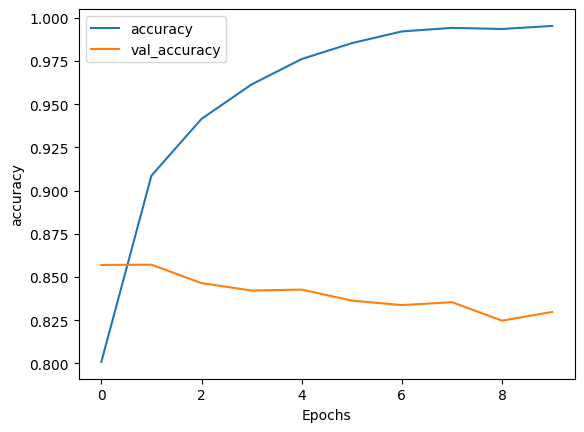

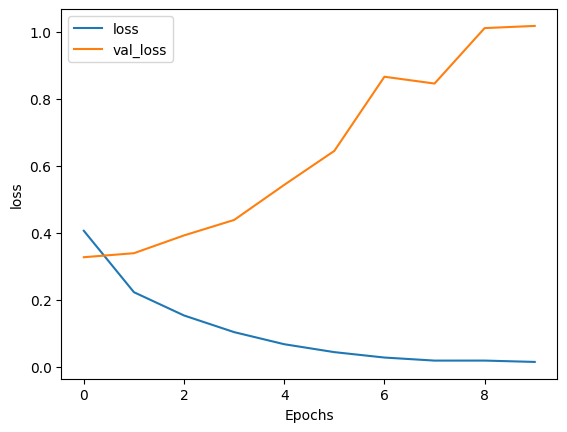

In [11]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')